# KAN: Kolmogorov–Arnold Networks With Resnet18

Implementation of KAN architecture with proper feature extraction and attention mechanisms for MRI image analysis.

## 1. Import Dependencies

Import required libraries and modules for implementing KAN.

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

## 2. Data Loading and Preprocessing

Setup data pipelines with proper transforms for MRI images.

In [2]:
# Data directories
TRAIN_DIR = "/home/mhs/thesis/Brain MRI ND-5 Dataset/Training"
TEST_DIR  = "/home/mhs/thesis/Brain MRI ND-5 Dataset/Testing"

# Define image transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((224, 224)),                # Resize for backbone
    transforms.ToTensor(),                        # Convert to tensor
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Repeat grayscale to 3 channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])   # ImageNet normalization
])

# Create datasets
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=transform)
test_dataset  = datasets.ImageFolder(TEST_DIR,  transform=transform)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                         num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False,
                         num_workers=4, pin_memory=True)

num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")
print(f"Training samples: {len(train_dataset)}")
print(f"Testing samples:  {len(test_dataset)}")

Number of classes: 4
Training samples: 13927
Testing samples:  3961


## 3. Define KAN Architecture

Implement the Kernel Attention Network model with proper feature extraction.

In [ ]:
# class KernelAttention(nn.Module):
#     def __init__(self, in_dim, kernel_size=7):
#         super().__init__()
#         self.conv = nn.Conv2d(in_dim, in_dim, kernel_size=kernel_size, 
#                              padding=kernel_size//2, groups=in_dim)
#         self.spatial_gate = nn.Sequential(
#             nn.Conv2d(in_dim, 1, kernel_size=1),
#             nn.Sigmoid()
#         )
        
#     def forward(self, x):
#         # Local feature aggregation
#         local_feat = self.conv(x)
#         # Generate attention weights
#         attn = self.spatial_gate(local_feat)
#         return x * attn

# class KANModel(nn.Module):
#     def __init__(self, num_classes, backbone='resnet18'):
#         super().__init__()
        
#         # 1. Feature Extraction Backbone
#         if backbone == 'resnet18':
#             base = models.resnet18(pretrained=True)
#             self.feature_dim = 512
#         else:
#             raise ValueError(f"Unsupported backbone: {backbone}")
            
#         # Remove the final FC layer
#         self.features = nn.Sequential(*list(base.children())[:-2])
        
#         # 2. Kernel Attention Module
#         self.attention = KernelAttention(self.feature_dim)
        
#         # 3. Global Average Pooling
#         self.gap = nn.AdaptiveAvgPool2d(1)
        
#         # 4. Classifier
#         self.classifier = nn.Sequential(
#             nn.Linear(self.feature_dim, 256),
#             nn.ReLU(inplace=True),
#             nn.Dropout(0.5),
#             nn.Linear(256, num_classes)
#         )
        
#     def forward(self, x):
#         # Extract features
#         x = self.features(x)  # [B, 512, H', W']
        
#         # Apply kernel attention
#         x = self.attention(x)
        
#         # Global average pooling
#         x = self.gap(x)      # [B, 512, 1, 1]
#         x = x.view(x.size(0), -1)  # [B, 512]
        
#         # Classification
#         return self.classifier(x)

In [3]:
class BSpline(nn.Module):
    """B-spline implementation for KAN."""
    def __init__(self, in_dim, grid_size=5, degree=3):
        super().__init__()
        self.in_dim = in_dim
        self.grid_size = grid_size
        self.degree = degree
        
        # Learnable control points
        self.control_points = nn.Parameter(torch.randn(in_dim, grid_size))
        
        # Fixed grid points from 0 to 1
        self.register_buffer('grid', torch.linspace(0, 1, grid_size))
        
    def forward(self, x):
        # x shape: [B, C, N]
        B, C, N = x.shape
        
        # Normalize input to [0, 1]
        x_norm = (x - x.min(dim=2, keepdim=True)[0]) / (x.max(dim=2, keepdim=True)[0] - x.min(dim=2, keepdim=True)[0] + 1e-8)
        
        # Initialize output tensor
        out = torch.zeros_like(x)
        
        # Compute B-spline weights for each channel
        for c in range(C):
            # Expand grid for broadcasting
            grid_expanded = self.grid.view(1, -1)  # [1, grid_size]
            x_expanded = x_norm[:, c, :].unsqueeze(2)  # [B, N, 1]
            
            # Compute weights using RBF
            weights = torch.exp(-((x_expanded - grid_expanded) ** 2) / 0.1)  # [B, N, grid_size]
            weights = weights / (weights.sum(dim=2, keepdim=True) + 1e-8)
            
            # Apply weights to control points
            out[:, c, :] = torch.matmul(weights, self.control_points[c].unsqueeze(1)).squeeze(2)
            
        return out

class KANAttention(nn.Module):
    def __init__(self, in_dim, grid_size=5, degree=3):
        super().__init__()
        self.in_dim = in_dim
        
        # Modified KAN layer
        self.spline = BSpline(in_dim, grid_size, degree)
        self.attention_conv = nn.Conv1d(in_dim, 1, 1)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        # x: [B, C, H, W]
        B, C, H, W = x.shape
        
        # Reshape to [B, C, H*W]
        x_flat = x.view(B, C, -1)
        
        # Apply B-spline transformation
        x_spline = self.spline(x_flat)
        
        # Generate attention weights
        attn = self.attention_conv(x_spline)  # [B, 1, H*W]
        attn = self.activation(attn)
        
        # Reshape attention back to spatial dimensions
        attn = attn.view(B, 1, H, W)
        
        # Apply attention
        return x * attn.expand_as(x)

In [5]:
class KANModel(nn.Module):
    def __init__(self, num_classes, backbone='resnet18'):
        super().__init__()
        
        # 1. Feature Extraction Backbone
        if backbone == 'resnet18':
            base = models.resnet18(pretrained=True)
            self.feature_dim = 512
        else:
            raise ValueError(f"Unsupported backbone: {backbone}")
            
        # Remove final FC layer and keep feature extractor
        self.features = nn.Sequential(*list(base.children())[:-2])
        
        # 2. KAN Attention Module
        self.attention = KANAttention(self.feature_dim)
        
        # 3. Global Average Pooling
        self.gap = nn.AdaptiveAvgPool2d(1)
        
        # 4. Final Classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        # Feature extraction
        x = self.features(x)  # [B, 512, H', W']
        
        # Apply KAN attention
        x = self.attention(x)
        
        # Global average pooling
        x = self.gap(x)      # [B, 512, 1, 1]
        x = x.view(x.size(0), -1)  # [B, 512]
        
        # Classification
        return self.classifier(x)

## 4. Training Configuration

Setup training parameters and optimization configuration.

In [6]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model
model = KANModel(num_classes=num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Learning rate scheduler (removed verbose parameter)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max',
    factor=0.5,
    patience=5
)

Using device: cuda


/home/mhs/miniforge3/envs/thesis/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mhs/miniforge3/envs/thesis/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 5. Training and Evaluation Loop

Implement the main training loop with evaluation metrics.

In [7]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    for images, labels in tqdm(loader, desc='Training'):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track metrics
        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    # Compute epoch metrics
    epoch_loss = running_loss / len(loader)
    epoch_acc = accuracy_score(all_labels, all_preds)
    
    return epoch_loss, epoch_acc

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Evaluating'):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Compute metrics
    avg_loss = running_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, 
                                target_names=train_dataset.classes)
    
    return avg_loss, accuracy, report

# Training loop
num_epochs = 10
best_acc = 0.0

for epoch in range(1, num_epochs + 1):
    # Training phase
    train_loss, train_acc = train_epoch(model, train_loader, criterion, 
                                      optimizer, device)
    
    # Evaluation phase
    val_loss, val_acc, val_report = evaluate(model, test_loader, criterion, device)
    
    # Learning rate scheduling
    scheduler.step(val_acc)
    
    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'kan_best_model.pth')
    
    # Print epoch results
    print(f"\nEpoch {epoch}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Print detailed validation report every 5 epochs
    if epoch % 5 == 0:
        print("\nValidation Report:")
        print(val_report)

# Final evaluation
print("\nLoading best model for final evaluation...")
model.load_state_dict(torch.load('kan_best_model.pth'))
test_loss, test_acc, test_report = evaluate(model, test_loader, criterion, device)

print("\nFinal Test Results:")
print(f"Test Accuracy: {test_acc:.4f}")
print("\nDetailed Classification Report:")
print(test_report)

Evaluating: 100%|██████████| 124/124 [00:07<00:00, 16.10it/s]



Epoch 1/10
Train Loss: 0.2299, Train Acc: 0.9281
Val Loss: 0.1662, Val Acc: 0.9578


Evaluating: 100%|██████████| 124/124 [00:15<00:00,  8.18it/s]



Epoch 2/10
Train Loss: 0.0605, Train Acc: 0.9846
Val Loss: 0.2100, Val Acc: 0.9488


Evaluating: 100%|██████████| 124/124 [00:13<00:00,  9.05it/s]



Epoch 3/10
Train Loss: 0.0453, Train Acc: 0.9872
Val Loss: 0.1672, Val Acc: 0.9631


Evaluating: 100%|██████████| 124/124 [00:15<00:00,  8.19it/s]



Epoch 4/10
Train Loss: 0.0329, Train Acc: 0.9920
Val Loss: 0.1307, Val Acc: 0.9720


Evaluating: 100%|██████████| 124/124 [00:14<00:00,  8.51it/s]



Epoch 5/10
Train Loss: 0.0232, Train Acc: 0.9938
Val Loss: 0.1708, Val Acc: 0.9634

Validation Report:
              precision    recall  f1-score   support

      glioma       0.99      0.91      0.95      1208
  meningioma       0.93      0.98      0.95       930
        none       0.94      0.99      0.97       831
   pituitary       0.98      0.98      0.98       992

    accuracy                           0.96      3961
   macro avg       0.96      0.97      0.96      3961
weighted avg       0.96      0.96      0.96      3961



Evaluating: 100%|██████████| 124/124 [-1:59:15<00:00, -2.71it/s]



Epoch 6/10
Train Loss: 0.0190, Train Acc: 0.9949
Val Loss: 0.1992, Val Acc: 0.9626


Evaluating: 100%|██████████| 124/124 [00:07<00:00, 15.79it/s]



Epoch 7/10
Train Loss: 0.0212, Train Acc: 0.9942
Val Loss: 0.1688, Val Acc: 0.9647


Evaluating: 100%|██████████| 124/124 [00:07<00:00, 16.64it/s]



Epoch 8/10
Train Loss: 0.0191, Train Acc: 0.9948
Val Loss: 0.1798, Val Acc: 0.9662


Evaluating: 100%|██████████| 124/124 [00:07<00:00, 17.13it/s]



Epoch 9/10
Train Loss: 0.0142, Train Acc: 0.9962
Val Loss: 0.1863, Val Acc: 0.9669


Evaluating: 100%|██████████| 124/124 [00:07<00:00, 16.78it/s]



Epoch 10/10
Train Loss: 0.0176, Train Acc: 0.9953
Val Loss: 0.1705, Val Acc: 0.9647

Validation Report:
              precision    recall  f1-score   support

      glioma       0.99      0.93      0.96      1208
  meningioma       0.93      0.98      0.95       930
        none       0.95      1.00      0.97       831
   pituitary       0.99      0.97      0.98       992

    accuracy                           0.96      3961
   macro avg       0.96      0.97      0.97      3961
weighted avg       0.97      0.96      0.96      3961


Loading best model for final evaluation...


Evaluating: 100%|██████████| 124/124 [00:07<00:00, 15.86it/s]


Final Test Results:
Test Accuracy: 0.8346

Detailed Classification Report:
              precision    recall  f1-score   support

      glioma       0.94      0.55      0.70      1208
  meningioma       0.92      0.92      0.92       930
        none       0.61      1.00      0.76       831
   pituitary       0.99      0.95      0.97       992

    accuracy                           0.83      3961
   macro avg       0.87      0.86      0.84      3961
weighted avg       0.88      0.83      0.83      3961



Evaluating: 100%|██████████| 124/124 [00:02<00:00, 52.30it/s]


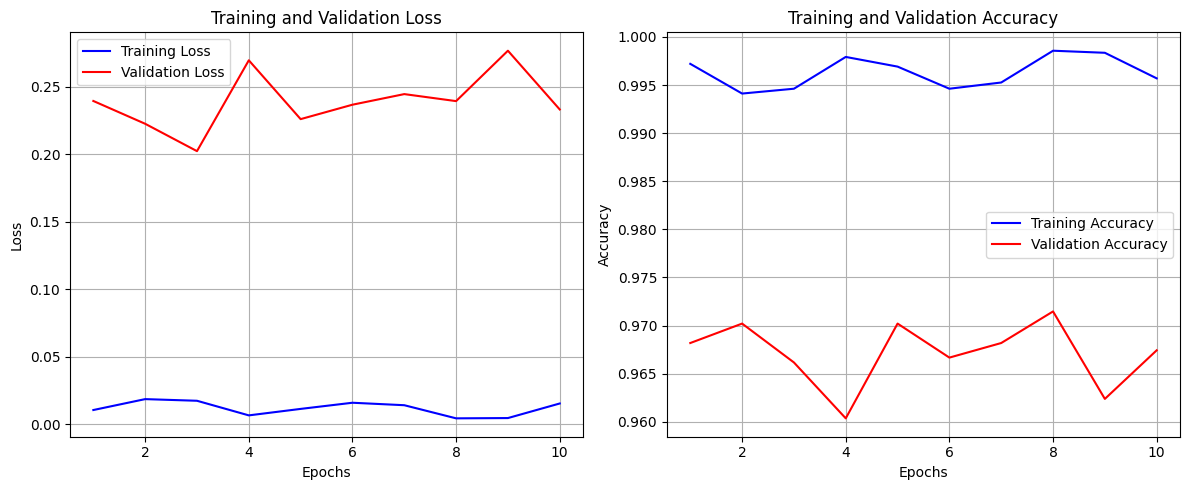

In [7]:
import matplotlib.pyplot as plt

# Modify the training loop to store metrics
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(1, num_epochs + 1):
    # Training phase
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Evaluation phase
    val_loss, val_acc, val_report = evaluate(model, test_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # ... rest of your existing training loop code ...

# Plotting
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, 'b-', label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accs, 'b-', label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accs, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()